In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import string
import re
import collections
from sklearn import  preprocessing
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import make_scorer, f1_score, accuracy_score, mean_absolute_error, confusion_matrix
import optuna
from lofo import LOFOImportance, Dataset, plot_importance
%matplotlib inline
import itertools


In [2]:
# READ DATA 
train_df = pd.read_json('train.json.zip')
test_df = pd.read_json('test.json.zip')

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 4 to 124009
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   bathrooms        49352 non-null  float64
 1   bedrooms         49352 non-null  int64  
 2   building_id      49352 non-null  object 
 3   created          49352 non-null  object 
 4   description      49352 non-null  object 
 5   display_address  49352 non-null  object 
 6   features         49352 non-null  object 
 7   latitude         49352 non-null  float64
 8   listing_id       49352 non-null  int64  
 9   longitude        49352 non-null  float64
 10  manager_id       49352 non-null  object 
 11  photos           49352 non-null  object 
 12  price            49352 non-null  int64  
 13  street_address   49352 non-null  object 
 14  interest_level   49352 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


**Our target 'INTEREST LEVEL' is an object as we can see above.

**Let's convert to the numeric to analyze easily

* 0 : low
* 1 : medium
* 2 : high

In [4]:
train_df['target'] = train_df['interest_level'].apply(lambda x: 0 if x=='low' 
                                                      else 1 if x=='medium' 
                                                      else 2) 
# train_df['low'] = train_df['interest_level'].apply(lambda x: 1 if x=='low' else 0)
# train_df['medium'] = train_df['interest_level'].apply(lambda x: 1 if x=='medium' else 0)
# train_df['high'] = train_df['interest_level'].apply(lambda x: 1 if x=='high' else 0)

### BASIC FEATURES

In [5]:
train_df['description'].iloc[0]

'Spacious 1 Bedroom 1 Bathroom in Williamsburg!Apartment Features:- Renovated Eat in Kitchen With Dishwasher- Renovated Bathroom- Beautiful Hardwood Floors- Lots of Sunlight- Great Closet Space- Freshly Painted- Heat and Hot Water Included- Live in Super Nearby L, J, M & G Trains !<br /><br />Contact Information:Kenneth BeakExclusive AgentC: 064-692-8838Email: kagglemanager@renthop.com, Text or Email to schedule a private viewing!<br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><br /><p><a  website_redacted '

In [6]:
# REMOVE UNNECESSARY WORDS FROM DESCRIPTION
train_df['description'] = train_df['description'].apply(lambda x: x.replace("<br />", ""))
train_df['description'] = train_df['description'].apply(lambda x: x.replace("br", ""))
train_df['description'] = train_df['description'].apply(lambda x: x.replace("<p><a", ""))

In [7]:
print(train_df['description'].iloc[0])

Spacious 1 Bedroom 1 Bathroom in Williamsburg!Apartment Features:- Renovated Eat in Kitchen With Dishwasher- Renovated Bathroom- Beautiful Hardwood Floors- Lots of Sunlight- Great Closet Space- Freshly Painted- Heat and Hot Water Included- Live in Super Nearby L, J, M & G Trains !Contact Information:Kenneth BeakExclusive AgentC: 064-692-8838Email: kagglemanager@renthop.com, Text or Email to schedule a private viewing!  website_redacted 


In [8]:
#basic features
train_df['rooms'] = train_df['bedrooms'] + train_df['bathrooms'] 

# count of photos #
train_df["num_photos"] = train_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)

# count of words present in description column #
train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))

# description contains email
regex = r'[\w\.-]+@[\w\.-]+'
train_df['has_email'] = train_df['description'].apply(lambda x: 1 if re.findall(regex, x) else 0)

# description contains phone
# description contains phone
train_df['has_phone'] = train_df['description'].apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: [s for s in x if s.isdigit()])\
        .apply(lambda x: len([s for s in x if len(str(s))==10]))\
        .apply(lambda x: 1 if x>0 else 0)

# CONVERT LOWER ALL OF WORDS
train_df[["features"]] = train_df[["features"]].apply(
    lambda _: [list(map(str.strip, map(str.lower, x))) for x in _])

### APPLY SAME OPERATIONS TO THE TEST DATA

In [9]:
# REMOVE UNNECESSARY WORDS FROM DESCRIPTION
test_df['description'] = test_df['description'].apply(lambda x: x.replace("<br />", ""))
test_df['description'] = test_df['description'].apply(lambda x: x.replace("br", ""))
test_df['description'] = test_df['description'].apply(lambda x: x.replace("<p><a", ""))

# FEATURE ENGINEERING
#basic features
test_df['rooms'] = test_df['bedrooms'] + test_df['bathrooms'] 

# count of photos #
test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

# description contains email
regex = r'[\w\.-]+@[\w\.-]+'
test_df['has_email'] = test_df['description'].apply(lambda x: 1 if re.findall(regex, x) else 0)

# description contains phone
test_df['has_phone'] = test_df['description'].apply(lambda x:re.sub('['+string.punctuation+']', '', x).split())\
        .apply(lambda x: [s for s in x if s.isdigit()])\
        .apply(lambda x: len([s for s in x if len(str(s))==10]))\
        .apply(lambda x: 1 if x>0 else 0)

# CONVERT LOWER ALL OF WORDS
test_df[["features"]] = test_df[["features"]].apply(
    lambda _: [list(map(str.strip, map(str.lower, x))) for x in _])

### MOST FREQUENT FEATURES EXTRACTION

In [10]:
feature_value_train = train_df['features'].tolist()
feature_value_test = test_df['features'].tolist()

feature_value_train
feature_value_test

feature_lst_train = []
feature_lst_test = []

for i in range(len(feature_value_train)):
    feature_lst_train += feature_value_train[i]
    
for i in range(len(feature_value_test)):
    feature_lst_test += feature_value_test[i]
# print(len(feature_lst)) # all features

uniq_feature_train = list(set(feature_lst_train))
uniq_feature_test = list(set(feature_lst_test))

# print(uniq_feature) #all unique features
len(uniq_feature_train)
len(uniq_feature_test)

1760

In [11]:
# see the frequency of each feature
def most_common(lst):
    features = collections.Counter(lst)
    feature_value = features.keys()
    frequency = features.values()
    data = [('feature_value', feature_value),
            ('frequency', frequency),]    
    df = pd.DataFrame.from_dict(dict(data))
    return df.sort_values(by = 'frequency', ascending = False)

df_features_train = most_common(feature_lst_train)
df_features_test = most_common(feature_lst_test)

df_features_train
df_features_test

,feature_value,frequency
0,elevator,39560
8,cats allowed,35654
4,hardwood floors,35597
7,dogs allowed,33172
10,doorman,31538
...,...,...
879,skyline and river views,1
878,individual ac,1
877,** wicked w50s! * massive studio supreme * mr ...,1
876,** no broker fee! * sprawling 2br home * all b...,1


In [12]:
def newColumn(name, df, series):
    feature = pd.Series(0,df.index,name = name)# data : 0
    for row,word in enumerate(series):
        if name in word:
            feature.iloc[row] = 1
    df[name] = feature # feature : series ; value in series : 1 or 0
    return df

# select features based on frequency
facilities = ['elevator', 'cats allowed', 'hardwood floors', 'dogs allowed', 'doorman', 'dishwasher', 'no fee', 'laundry in building', 'fitness center']
for name in facilities:
    train_df = newColumn(name, train_df, train_df['features'])
    test_df = newColumn(name, test_df, test_df['features'])

### Features after extraction

In [13]:
print(train_df['features'].iloc[0])

['dining room', 'pre-war', 'laundry in building', 'dishwasher', 'hardwood floors', 'dogs allowed', 'cats allowed']


### DATA VISUALIZATION

C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


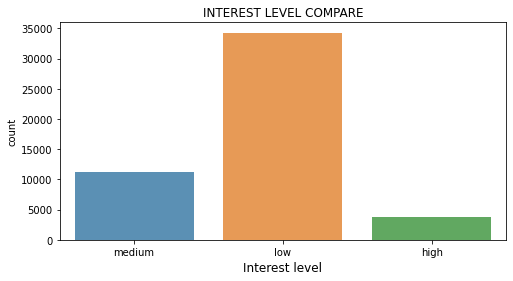

In [14]:
plt.figure(figsize=(8,4))
colors = ['lightcoral','gold','lightblue']
sns.countplot(train_df['interest_level'], alpha=0.8)
plt.title("INTEREST LEVEL COMPARE")
plt.xlabel('Interest level', fontsize=12)
plt.show()

- As we can see low level is highly more than other interest levels

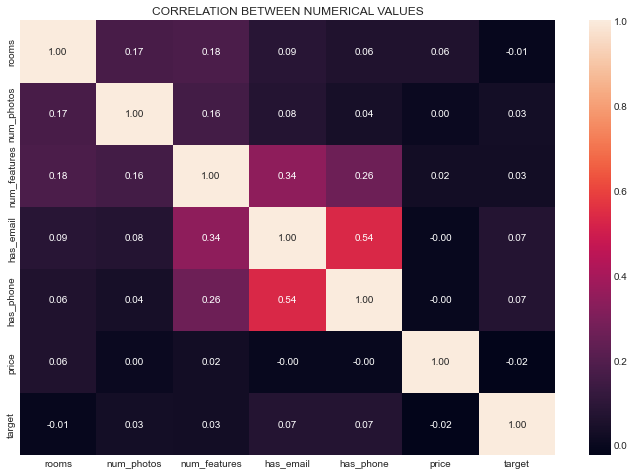

In [15]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(12,8))
plt.title("CORRELATION BETWEEN NUMERICAL VALUES")
num_col = ["rooms", "num_photos", "num_features", "has_email", "has_phone", "price", "target"]
sns.heatmap(train_df[num_col].corr(), annot = True, fmt = ".2f")
plt.show()

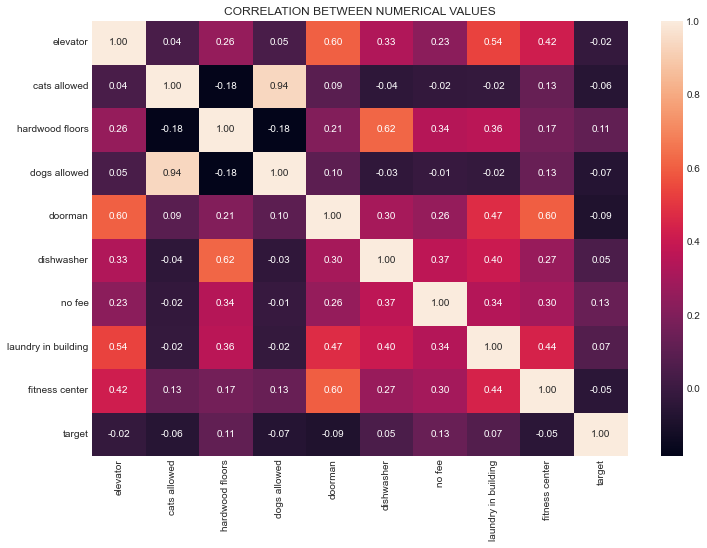

In [16]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize=(12,8))
plt.title("CORRELATION BETWEEN NUMERICAL VALUES")
num_col = ['elevator', 'cats allowed', 'hardwood floors', 'dogs allowed', 'doorman', 'dishwasher', 'no fee', 'laundry in building', 'fitness center', 'target']
sns.heatmap(train_df[num_col].corr(), annot = True, fmt = ".2f")
plt.show()

C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


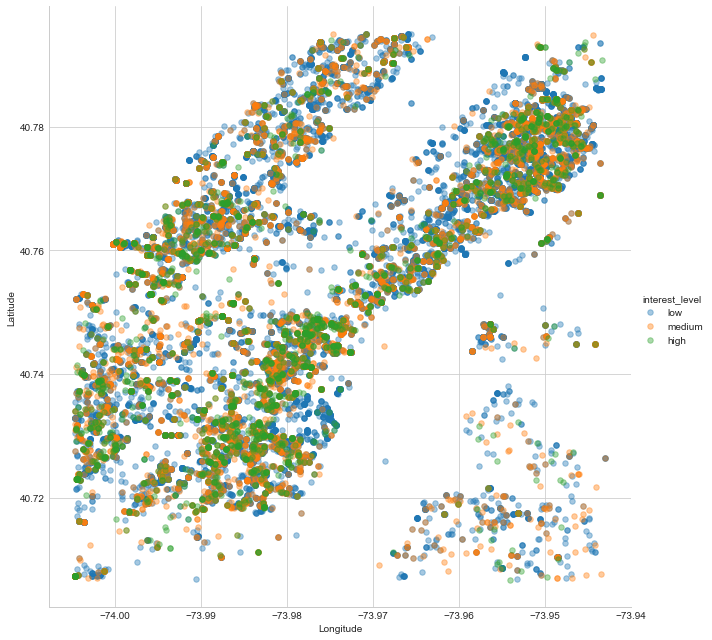

In [17]:
### Rent interest graph of New-York
sns.lmplot(x="longitude", y="latitude", fit_reg=False, hue='interest_level',
           hue_order=['low', 'medium', 'high'], size=9, scatter_kws={'alpha':0.4,'s':30},
           data=train_df[(train_df.longitude>train_df.longitude.quantile(0.1))
                        &(train_df.longitude<train_df.longitude.quantile(0.9))
                        &(train_df.latitude>train_df.latitude.quantile(0.1))                           
                        &(train_df.latitude<train_df.latitude.quantile(0.9))]);
plt.xlabel('Longitude');
plt.ylabel('Latitude');

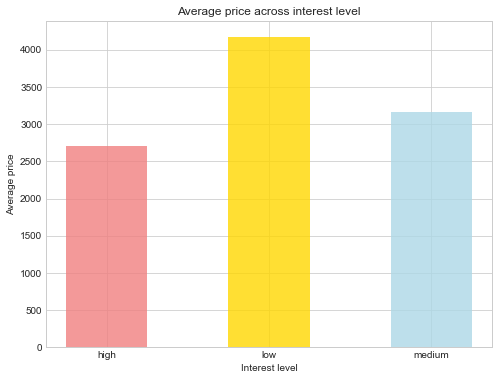

In [18]:
### Price exploration
prices=train_df.groupby('interest_level', as_index=False)['price'].mean()
colors = ['lightcoral','gold','lightblue']

fig=plt.figure(figsize=(8,6))
plt.bar(prices.interest_level, prices.price, color=colors, width=0.5, alpha=0.8)
#set titles
plt.xlabel('Interest level')
plt.ylabel('Average price')
plt.title('Average price across interest level')
plt.show()

In [19]:
train_df.groupby(['building_id', 'manager_id', 'interest_level']).count()

bathrooms  \
building_id                      manager_id                       interest_level              
0                                001ce808ce1720e24a9510e014c69707 low                    10   
                                 003fc4e9a70053082f131b1054966aaf low                     1   
                                 00a8d77892cab18fffaa22a751f1f8eb low                     3   
                                 00f526d80353a50a52bbc26919e7ed5a low                     1   
                                 01287194f20de51872e81f660def4784 low                     8   
...                                                                                     ...   
ffde4f77049b631ee532fa9e0ebdd95d 41735645e0f8f13993c42894023f8e58 low                     1   
                                 f01d80f465348a6054bd7a9004af53b4 medium                  1   
ffe55387cd931c117ee1b8446f21953b 1a4dd24b22749ffaa3398b1b1b61c9ff low                     1   
fff0a02ad82421c226c6d6765a0dde57 7efb139d6df9fc594c4db6ca96b8a1e7 low                     1   
fff5915444b98b72a44a9456901f083c b944623e2af9b605eb0cba5236ee5f8e low                     2   

                                                                                  bedrooms  \
building_id                      manager_id                       interest_level             
0                                001ce808ce1720e24a9510e014c69707 low                   10   
                                 003fc4e9a70053082f131b1054966aaf low                    1   
                                 00a8d77892cab18fffaa22a751f1f8eb low                    3   
                                 00f526d80353a50a52bbc26919e7ed5a low                    1   
                                 01287194f20de51872e81f660def4784 low                    8   
...                                                                                    ...   
ffde4f77049b631ee532fa9e0ebdd95d 41735645e0f8f13993c42894023f8e58 low                    1   
                                 f01d80f465348a6054bd7a9004af53b4 medium                 1   
ffe55387cd931c117ee1b8446f21953b 1a4dd24b22749ffaa3398b1b1b61c9ff low                    1   
fff0a02ad82421c226c6d6765a0dde57 7efb139d6df9fc594c4db6ca96b8a1e7 low                    1   
fff5915444b98b72a44a9456901f083c b944623e2af9b605eb0cba5236ee5f8e low                    2   

                                                                                  created  \
building_id                      manager_id                       interest_level            
0                                001ce808ce1720e24a9510e014c69707 low                  10   
                                 003fc4e9a70053082f131b1054966aaf low                   1   
                                 00a8d77892cab18fffaa22a751f1f8eb low                   3   
                                 00f526d80353a50a52bbc26919e7ed5a low                   1   
                                 01287194f20de51872e81f660def4784 low                   8   
...                                                                                   ...   
ffde4f77049b631ee532fa9e0ebdd95d 41735645e0f8f13993c42894023f8e58 low                   1   
                                 f01d80f465348a6054bd7a9004af53b4 medium                1   
ffe55387cd931c117ee1b8446f21953b 1a4dd24b22749ffaa3398b1b1b61c9ff low                   1   
fff0a02ad82421c226c6d6765a0dde57 7efb139d6df9fc594c4db6ca96b8a1e7 low                   1   
fff5915444b98b72a44a9456901f083c b944623e2af9b605eb0cba5236ee5f8e low                   2   

                                                                                  description  \
building_id                      manager_id                       interest_level                
0                                001ce808ce1720e24a9510e014c69707 low                      10   
                                 003fc4e9a70053082f131b1054966aaf low                       1   
                         

- WORDCLOUD SHOWS US MOST FREQUENT WORDS IN THE DATASET, DEPENDS ON THE FREQUENCY WORDS SIZE IS GETTING BIGGER

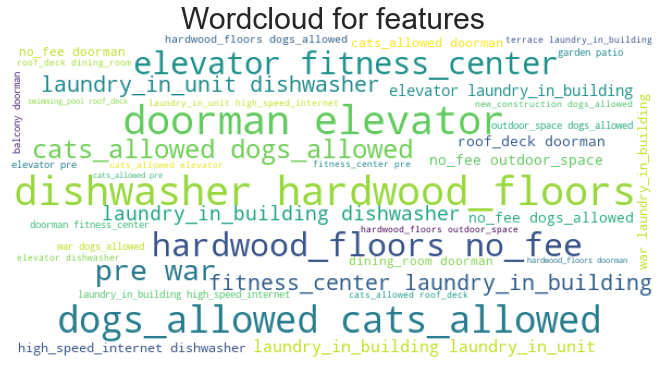

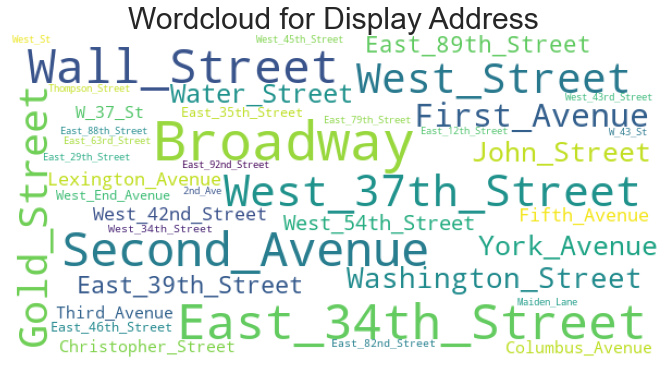

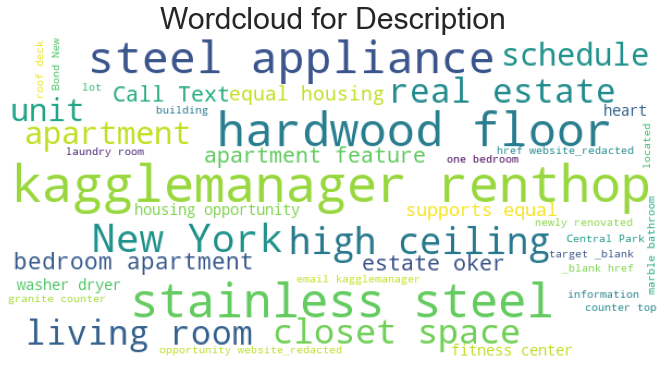

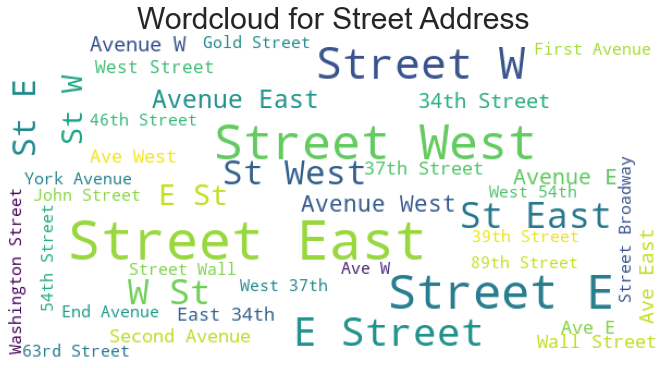

In [20]:
#WORDCLOUD FOR DESCRIPTION AND DISPLAY ADDRESS
#Preprocessing
text = ''
text_da = ''
text_desc = ''
text_str = ''
for ind, row in train_df.iterrows():
    for feature in row['features']:
        text = " ".join([text, "_".join(feature.strip().split(" "))])
    text_da = " ".join([text_da,"_".join(row['display_address'].strip().split(" "))])
    text_desc = " ".join([text_desc, row['description']])
    text_str = " ".join([text_str, row['street_address']])
text = text.strip()
text_da = text_da.strip()
text_desc = text_desc.strip()
text_str = text_str.strip()


# wordcloud for features
plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(text)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Wordcloud for features", fontsize=30)
plt.axis("off")
plt.show()


# wordcloud for display address
plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(text_da)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Wordcloud for Display Address", fontsize=30)
plt.axis("off")
plt.show()


# wordcloud for description
plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(text_desc)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Wordcloud for Description", fontsize=30)
plt.axis("off")
plt.show()

# wordcloud for street address
plt.figure(figsize=(12,6))
wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(text_str)
wordcloud.recolor(random_state=0)
plt.imshow(wordcloud)
plt.title("Wordcloud for Street Address", fontsize=30)
plt.axis("off")
plt.show()

### DROP UNNECESSARY COLUMNS

In [21]:
# TRAINING DATASET
train_df.drop('interest_level', axis=1, inplace=True)
train_df.drop('created', axis=1, inplace=True)
train_df.drop('description', axis=1, inplace=True)
train_df.drop('features', axis=1, inplace=True)
train_df.drop('photos', axis=1, inplace=True)

# TEST DATASET
test_df.drop('created', axis=1, inplace=True)
test_df.drop('description', axis=1, inplace=True)
test_df.drop('features', axis=1, inplace=True)
test_df.drop('photos', axis=1, inplace=True)

### LABEL ECONDING FOR CATEGORICAL VARIABLES

In [22]:
categorical = ["display_address", "manager_id", "building_id", "street_address"]
for f in categorical:
        if train_df[f].dtype=='object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))

## XGBOOST

In [23]:
X = train_df.drop(['target'], axis = 1)
y = train_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = .3,
                                                    random_state = 5,
                                                   stratify = y)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

In [24]:
kf = KFold(n_splits=5, shuffle=False)

X_train = X_train.values
y_train = y_train.values
scores = []

for train, test in kf.split(X_train, y_train):
    model = XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth = 10)
    model.fit(X_train[train], y_train[train])
    scores.append(model.score(X_train[test], y_train[test]))

C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:54:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:55:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:57:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:59:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
def objective(trial):
    params = {
        'booster':trial.suggest_categorical('booster', ['gbtree', 'dart', 'gblinear']),
        'learning_rate':trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        'max_depth':trial.suggest_int("max_depth", 3, 11),
        'subsample':trial.suggest_uniform("subsample", 0.0, 1.0),
        'colsample_bytree':trial.suggest_uniform("colsample_bytree", 0.0, 1.0),
    }

    model = XGBClassifier(**params)
    cv = KFold(n_splits=3, shuffle=True, random_state=None)
    scorer = make_scorer(f1_score, greater_is_better=True)
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    f1_scores = f1_score(y_test, pred_labels, average='micro')
    return f1_scores

In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

[I 2021-09-28 20:03:24,539] A new study created in memory with name: no-name-daebf5af-b96e-4a59-b6ed-902aa132ab62
[I 2021-09-28 20:03:24,604] Trial 0 finished with value: 0.6946508172362555 and parameters: {'booster': 'gblinear', 'learning_rate': 0.020292260641180088, 'max_depth': 11, 'subsample': 0.9646159593651782, 'colsample_bytree': 0.26122479208661264}. Best is trial 0 with value: 0.6946508172362555.
[I 2021-09-28 20:03:24,657] Trial 1 finished with value: 0.6948534377954884 and parameters: {'booster': 'gblinear', 'learning_rate': 0.03971064264905856, 'max_depth': 6, 'subsample': 0.9427153420848906, 'colsample_bytree': 0.1649452021398924}. Best is trial 1 with value: 0.6948534377954884.


[20:03:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:03:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:03:25,033] Trial 2 finished with value: 0.7147102526002973 and parameters: {'booster': 'gbtree', 'learning_rate': 0.0671745658414657, 'max_depth': 8, 'subsample': 0.6354989062342745, 'colsample_bytree': 0.6553132346094781}. Best is trial 2 with value: 0.7147102526002973.
[I 2021-09-28 20:03:25,450] Trial 3 finished with value: 0.7099148993651221 and parameters: {'booster': 'dart', 'learning_rate': 0.0169237910821856, 'max_depth': 10, 'subsample': 0.4069375142820816, 'colsample_bytree': 0.32822587227993383}. Best is trial 2 with value: 0.7147102526002973.
[I 2021-09-28 20:03:25,502] Trial 4 finished with value: 0.687221396731055 and parameters: {'booster': 'gblinear', 'learning_rate': 0.08821518846399543, 'max_depth': 3, 'subsample': 0.2375734164074117, 'colsample_bytree': 0.9881174499320622}. Best is trial 2 with value: 0.7147102526002973.


[20:03:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:03:26,027] Trial 5 finished with value: 0.7138997703633662 and parameters: {'booster': 'gbtree', 'learning_rate': 0.02385104822426317, 'max_depth': 10, 'subsample': 0.7450124631332764, 'colsample_bytree': 0.8659665505600008}. Best is trial 2 with value: 0.7147102526002973.
[I 2021-09-28 20:03:26,144] Trial 6 finished with value: 0.6794542752937998 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08883641577400002, 'max_depth': 6, 'subsample': 0.05337516976559675, 'colsample_bytree': 0.09281149045173487}. Best is trial 2 with value: 0.7147102526002973.
[I 2021-09-28 20:03:26,295] Trial 7 finished with value: 0.6928947723895718 and parameters: {'booster': 'gbtree', 'learning_rate': 0.013574350314016949, 'max_depth': 3, 'subsample': 0.42068000662224314, 'colsample_bytree': 0.6816829496135494}. Best is trial 2 with value: 0.7147102526002973.
[I 2021-09-28 20:03:26,546] Trial 8 finished with value: 0.7041064433337836 and parameters: {'booster': 'dart', 'learning_rat

[20:03:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:03:26,963] Trial 10 finished with value: 0.7116709442118059 and parameters: {'booster': 'gbtree', 'learning_rate': 0.050320430923254944, 'max_depth': 8, 'subsample': 0.645510683957235, 'colsample_bytree': 0.5290571385336701}. Best is trial 2 with value: 0.7147102526002973.
[I 2021-09-28 20:03:27,429] Trial 11 finished with value: 0.7138997703633662 and parameters: {'booster': 'gbtree', 'learning_rate': 0.022554773252792207, 'max_depth': 9, 'subsample': 0.6911471222635495, 'colsample_bytree': 0.6931318662683087}. Best is trial 2 with value: 0.7147102526002973.
[I 2021-09-28 20:03:27,822] Trial 12 finished with value: 0.712481426448737 and parameters: {'booster': 'gbtree', 'learning_rate': 0.05274892043099996, 'max_depth': 8, 'subsample': 0.6809253650884115, 'colsample_bytree': 0.7610409942075269}. Best is trial 2 with value: 0.7147102526002973.
[I 2021-09-28 20:03:28,270] Trial 13 finished with value: 0.7137646899905444 and parameters: {'booster': 'gbtree', 'learning_ra

[20:03:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:03:37,122] Trial 31 finished with value: 0.718019721734432 and parameters: {'booster': 'dart', 'learning_rate': 0.0181436050865597, 'max_depth': 11, 'subsample': 0.8906079260823732, 'colsample_bytree': 0.7384794446675637}. Best is trial 29 with value: 0.721194110495745.
[I 2021-09-28 20:03:37,816] Trial 32 finished with value: 0.7179521815480211 and parameters: {'booster': 'dart', 'learning_rate': 0.01882680340509867, 'max_depth': 11, 'subsample': 0.8661220162726049, 'colsample_bytree': 0.7397357999905892}. Best is trial 29 with value: 0.721194110495745.
[I 2021-09-28 20:03:38,529] Trial 33 finished with value: 0.7192354450898284 and parameters: {'booster': 'dart', 'learning_rate': 0.013538808018023997, 'max_depth': 11, 'subsample': 0.9096978750081544, 'colsample_bytree': 0.826835748868562}. Best is trial 29 with value: 0.721194110495745.
[I 2021-09-28 20:03:39,239] Trial 34 finished with value: 0.7201810076995813 and parameters: {'booster': 'dart', 'learning_rate': 0.

[20:03:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:03:40,793] Trial 37 finished with value: 0.7169390787518574 and parameters: {'booster': 'dart', 'learning_rate': 0.01355911140997535, 'max_depth': 11, 'subsample': 0.7771241734386887, 'colsample_bytree': 0.8300727501671011}. Best is trial 29 with value: 0.721194110495745.
[I 2021-09-28 20:03:41,113] Trial 38 finished with value: 0.6970147237606376 and parameters: {'booster': 'dart', 'learning_rate': 0.011906422502053116, 'max_depth': 4, 'subsample': 0.9274409070115799, 'colsample_bytree': 0.9430271432831436}. Best is trial 29 with value: 0.721194110495745.
[I 2021-09-28 20:03:41,193] Trial 39 finished with value: 0.6946508172362555 and parameters: {'booster': 'gblinear', 'learning_rate': 0.02142601599981189, 'max_depth': 10, 'subsample': 0.7521829934790993, 'colsample_bytree': 0.7950583896644295}. Best is trial 29 with value: 0.721194110495745.


[20:03:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:03:41,407] Trial 40 finished with value: 0.6930298527623936 and parameters: {'booster': 'dart', 'learning_rate': 0.014738804701204717, 'max_depth': 6, 'subsample': 0.8181107078519407, 'colsample_bytree': 0.01588622442765697}. Best is trial 29 with value: 0.721194110495745.
[I 2021-09-28 20:03:42,139] Trial 41 finished with value: 0.7176820208023774 and parameters: {'booster': 'dart', 'learning_rate': 0.016298016602411536, 'max_depth': 11, 'subsample': 0.9181864988252767, 'colsample_bytree': 0.6777726503532263}. Best is trial 29 with value: 0.721194110495745.
[I 2021-09-28 20:03:42,858] Trial 42 finished with value: 0.7161961367013372 and parameters: {'booster': 'dart', 'learning_rate': 0.012283881973886815, 'max_depth': 11, 'subsample': 0.8376319583898734, 'colsample_bytree': 0.6991834958272862}. Best is trial 29 with value: 0.721194110495745.
[I 2021-09-28 20:03:43,519] Trial 43 finished with value: 0.7131568283128461 and parameters: {'booster': 'dart', 'learning_rate

[20:03:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:03:46,070] Trial 48 finished with value: 0.7216668918006215 and parameters: {'booster': 'dart', 'learning_rate': 0.012372918087737834, 'max_depth': 11, 'subsample': 0.9655743598779992, 'colsample_bytree': 0.7652990096612262}. Best is trial 48 with value: 0.7216668918006215.
[I 2021-09-28 20:03:46,734] Trial 49 finished with value: 0.7160610563285155 and parameters: {'booster': 'dart', 'learning_rate': 0.012303351988637181, 'max_depth': 10, 'subsample': 0.958911401277666, 'colsample_bytree': 0.7820791613601907}. Best is trial 48 with value: 0.7216668918006215.
[I 2021-09-28 20:03:47,455] Trial 50 finished with value: 0.7201810076995813 and parameters: {'booster': 'dart', 'learning_rate': 0.010151891782989768, 'max_depth': 11, 'subsample': 0.9649906452644258, 'colsample_bytree': 0.66182652743338}. Best is trial 48 with value: 0.7216668918006215.
[I 2021-09-28 20:03:48,178] Trial 51 finished with value: 0.717209239497501 and parameters: {'booster': 'dart', 'learning_rate'

[20:03:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:03:57,792] Trial 67 finished with value: 0.7184249628528975 and parameters: {'booster': 'dart', 'learning_rate': 0.017791349917217533, 'max_depth': 11, 'subsample': 0.8626376949829242, 'colsample_bytree': 0.4828850535803974}. Best is trial 48 with value: 0.7216668918006215.
[I 2021-09-28 20:03:58,523] Trial 68 finished with value: 0.7189652843441848 and parameters: {'booster': 'dart', 'learning_rate': 0.011306096410324385, 'max_depth': 11, 'subsample': 0.6384818616599034, 'colsample_bytree': 0.8173956793520236}. Best is trial 48 with value: 0.7216668918006215.
[I 2021-09-28 20:03:59,099] Trial 69 finished with value: 0.7180872619208428 and parameters: {'booster': 'dart', 'learning_rate': 0.01260064570356716, 'max_depth': 10, 'subsample': 0.9674580868914424, 'colsample_bytree': 0.6229402938318169}. Best is trial 48 with value: 0.7216668918006215.
[I 2021-09-28 20:03:59,669] Trial 70 finished with value: 0.7157908955828718 and parameters: {'booster': 'dart', 'learning_ra

[20:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:04:04,776] Trial 79 finished with value: 0.7199783871403485 and parameters: {'booster': 'dart', 'learning_rate': 0.010913186886966556, 'max_depth': 11, 'subsample': 0.9765155569894821, 'colsample_bytree': 0.8008429505625304}. Best is trial 48 with value: 0.7216668918006215.
[I 2021-09-28 20:04:05,565] Trial 80 finished with value: 0.718830203971363 and parameters: {'booster': 'dart', 'learning_rate': 0.01557670217818206, 'max_depth': 11, 'subsample': 0.9784311359480626, 'colsample_bytree': 0.8016183517419672}. Best is trial 48 with value: 0.7216668918006215.
[I 2021-09-28 20:04:06,281] Trial 81 finished with value: 0.7174794002431447 and parameters: {'booster': 'dart', 'learning_rate': 0.010478721830830356, 'max_depth': 11, 'subsample': 0.9474722341024752, 'colsample_bytree': 0.6921893041484868}. Best is trial 48 with value: 0.7216668918006215.
[I 2021-09-28 20:04:07,125] Trial 82 finished with value: 0.7174794002431447 and parameters: {'booster': 'dart', 'learning_rat

[20:04:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytree", "max_depth", "subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[I 2021-09-28 20:04:18,563] Trial 99 finished with value: 0.6983655274888558 and parameters: {'booster': 'dart', 'learning_rate': 0.01462279862609719, 'max_depth': 4, 'subsample': 0.8820371149015385, 'colsample_bytree': 0.7237559712045788}. Best is trial 48 with value: 0.7216668918006215.


In [27]:
new_params = study.best_params

new_model = XGBClassifier(**new_params)
new_model.fit(X, y)
preds = new_model.predict(X_test)

print('Optimized SuperLearner accuracy: ', accuracy_score(y_test, preds))
print('Optimized SuperLearner f1-score: ', f1_score(y_test, preds, average='micro'))

C:\Users\burak\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:04:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Optimized SuperLearner accuracy:  0.8114953397271376
Optimized SuperLearner f1-score:  0.8114953397271376


In [28]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.7216668918006215
  Params: 
    booster: dart
    learning_rate: 0.012372918087737834
    max_depth: 11
    subsample: 0.9655743598779992
    colsample_bytree: 0.7652990096612262


In [29]:
print("All of accuracies")
print(scores)

print("Mean of accuracies")
print(np.mean(scores))

All of accuracies
[0.7479015918958032, 0.7416413373860182, 0.7445361123172674, 0.7346938775510204, 0.7344044000578955]
Mean of accuracies
0.7406354638416011


In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[33640   634    10]
 [ 6310  4851    68]
 [ 1294   843  1702]]


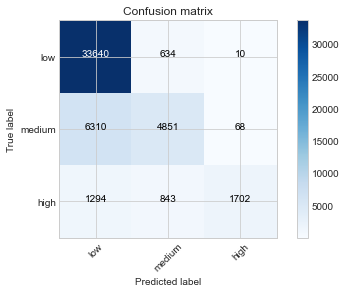

In [31]:
y_pred = new_model.predict(X)
cm = confusion_matrix(train_df['target'], y_pred)
np.set_printoptions(precision=2)

class_names = ['low', 'medium', 'high']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

### FEATURE IMPORTANCE BY LOFO

[20:05:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:05:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:06:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:07:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

  0%|          | 0/25 [00:00<?, ?it/s]

[20:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:09:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[20:26:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:26:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:27:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:28:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[20:42:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:43:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:44:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[20:58:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

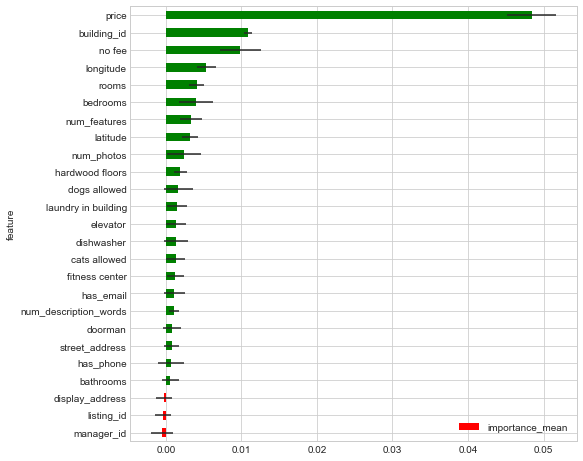

In [32]:
# define the validation scheme
cv = KFold(n_splits=4, shuffle=True, random_state=0)
scorer = make_scorer(mean_absolute_error, greater_is_better=False)
# define the binary target and the features
target = "target"
features = [col for col in train_df.columns if col != target]
dataset = Dataset(df=train_df, target=target, features=features)
# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, scoring=scorer, model=new_model, cv=cv)

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

# plot the means and standard deviations of the importances
plot_importance(importance_df)